Before importing the next packages, be sure to install the following packages:
python -m pip install transformers sentence-transformers datasets cohere

In [1]:
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from pinecone import Pinecone, ServerlessSpec
import os
from tqdm import tqdm
import cohere
import numpy as np
import warnings
from IPython.display import display
warnings.filterwarnings("ignore")

# Tutorial 3 - RAG Tutorial

In this tutorial we will be going through a simple RAG pipeline.

## What is RAG?
 - Stands for: Retrieval Augmented Generation
 - Retrieving relevant information and adding that information as context to the LLM

## Why do we need RAG?
#### Well... LLMs are cool, but flawed

 - They are static in time

 - They lack domain-specific knowledge

- They are black-boxes

 - They are expensive to operate

Adding relevant information to the prompt of the LLMs assists us in using the powers of LLM

#### RAG Pipeline:
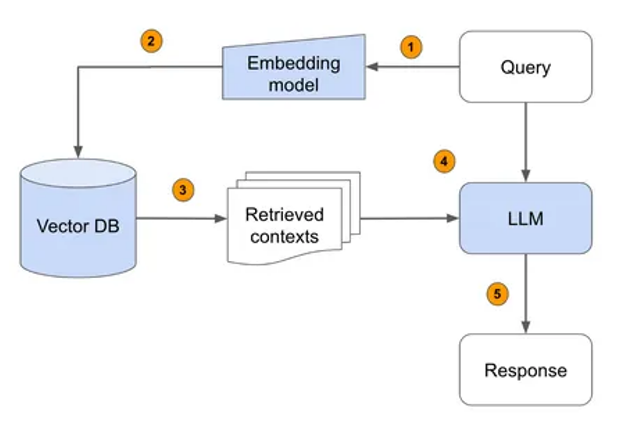

* An embedding model (For example, a sentence-transformer)

* A vector database, we will use the free-to-use Pinecone API (limited to 100k vectors)

* An LLM to chat with, we will use the CohereChat API (Similar to OpenAI's chatGPT, but free)

##### First things first - APIs

In [1]:
with open("Assignment 1/chohere_api_keys.txt") as f:
    COHERE_API_KEY = f.read().strip()
with open("Assignment 1/pinecone_api_key.txt") as f:
    PINECONE_API_KEY = f.read().strip()

We will use them later on...

## First Element - Embedding Model

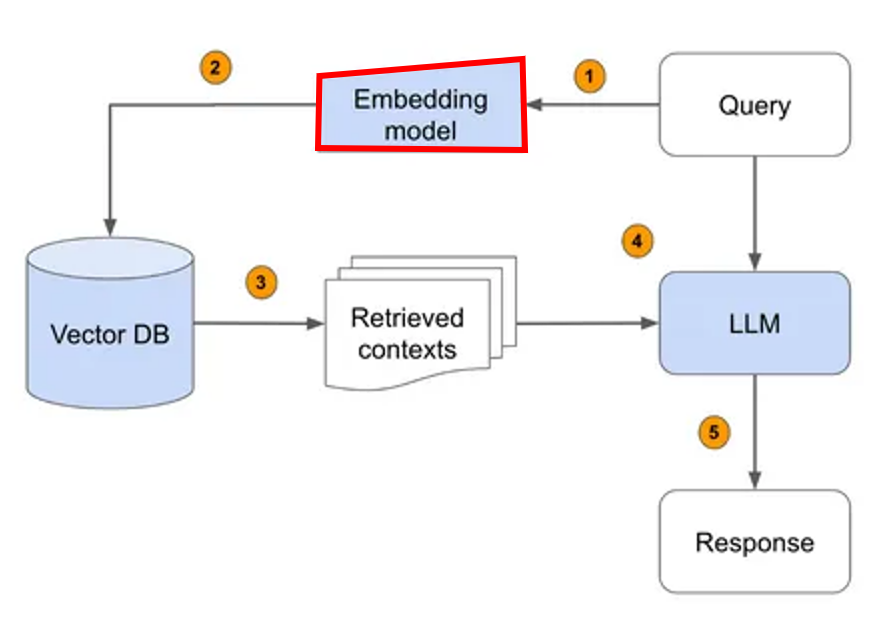

In [2]:
from sentence_transformers import SentenceTransformer

EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDING_MODEL)

More models can be found [here](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending)

In [3]:
def load_and_embedd_dataset(
        dataset_name: str = 'cnn_dailymail',
        split: str = 'train',
        model: SentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2'),
        text_field: str = 'highlights',
        rec_num: int = 400
) -> tuple:
    """
    Load a dataset and embedd the text field using a sentence-transformer model
    Args:
        dataset_name: The name of the dataset to load
        split: The split of the dataset to load
        model: The model to use for embedding
        text_field: The field in the dataset that contains the text
        rec_num: The number of records to load and embedd
    Returns:
        tuple: A tuple containing the dataset and the embeddings
    """
    from datasets import load_dataset
    
    print("Loading and embedding the dataset")
    
    # Load the dataset
    dataset = load_dataset(dataset_name, '3.0.0', split=split)
    
    # Embed the first `rec_num` rows of the dataset  
    embeddings = model.encode(dataset[text_field][:rec_num])
    
    print("Done!")
    return dataset, embeddings

In [23]:
DATASET_NAME = 'cnn_dailymail'

dataset, embeddings = load_and_embedd_dataset(
    dataset_name=DATASET_NAME,
    rec_num=40,
    model=model,
)
shape = embeddings.shape

Loading and embedding the dataset
Done!


Lets us look at the dataset and the embeddings

In [24]:
pd_dataset = dataset.to_pandas()
pd_dataset.head(5)

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [25]:
print(f"The embeddings shape: {embeddings.shape}")

The embeddings shape: (40, 384)


## Second Element - Vector Database
We will use Pinecone's free-to-use vectorDB

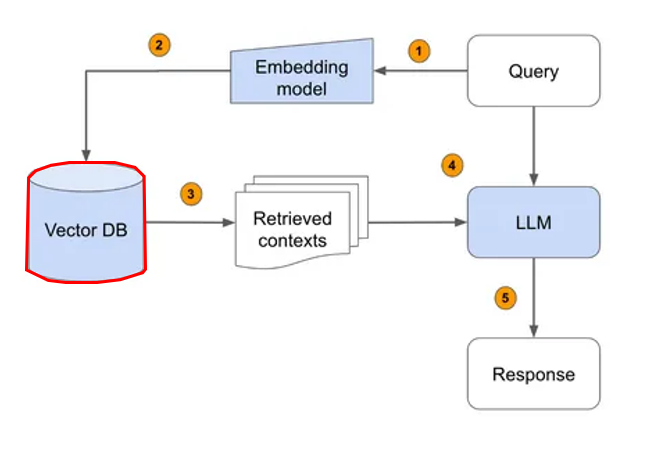

In [26]:
def create_pinecone_index(
        index_name: str,
        dimension: int,
        metric: str = 'cosine',
):
    """
    Create a pinecone index if it does not exist
    Args:
        index_name: The name of the index
        dimension: The dimension of the index
        metric: The metric to use for the index
    Returns:
        Pinecone: A pinecone object which can later be used for upserting vectors and connecting to VectorDBs
    """
    from pinecone import Pinecone, ServerlessSpec
    print("Creating a Pinecone index...")
    pc = Pinecone(api_key=PINECONE_API_KEY)
    existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]
    if index_name not in existing_indexes:
        pc.create_index(
            name=index_name,
            dimension=dimension,
            # Remember! It is crucial that the metric you will use in your VectorDB will also be a metric your embedding
            # model works well with!
            metric=metric,
            spec=ServerlessSpec(
                cloud="aws",
                region="us-east-1"
            )
        )
    print("Done!")
    return pc

In [27]:
INDEX_NAME = 'cnn-dailymail'

# Create the vector database
# We are passing the index_name and the size of our embeddings
pc = create_pinecone_index(INDEX_NAME, shape[1])

Creating a Pinecone index...
Done!


Now that we have created the vector database, let's add some data to it! 

In [28]:
def upsert_vectors(
        index: Pinecone,
        embeddings: np.ndarray,
        dataset: dict,
        text_field: str = 'highlights',
        batch_size: int = 128
):
    """
    Upsert vectors to a pinecone index
    Args:
        index: The pinecone index object
        embeddings: The embeddings to upsert
        dataset: The dataset containing the metadata
        batch_size: The batch size to use for upserting
    Returns:
        An updated pinecone index
    """
    print("Upserting the embeddings to the Pinecone index...")
    shape = embeddings.shape
    
    ids = [str(i) for i in range(shape[0])]
    meta = [{text_field: text} for text in dataset[text_field]]
    
    # create list of (id, vector, metadata) tuples to be upserted
    to_upsert = list(zip(ids, embeddings, meta))

    for i in tqdm(range(0, shape[0], batch_size)):
        i_end = min(i + batch_size, shape[0])
        index.upsert(vectors=to_upsert[i:i_end])
    return index


In [29]:
# Upsert the embeddings to the Pinecone index
index = pc.Index(INDEX_NAME)
index_upserted = upsert_vectors(index, embeddings, dataset)

Upserting the embeddings to the Pinecone index...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Let's view the index statistics!

In [36]:
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 40}},
 'total_vector_count': 40}

## Third Element - LLM
We will use [Cohere's chat API](https://cohere.com/chat)

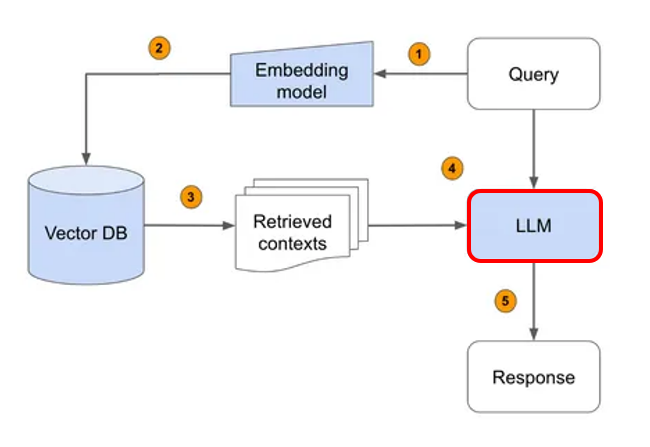

In [31]:
import cohere

#First lets write a query for the LLM
query = "How much money did Harry Potter star Daniel Radcliffe have when he was 18?"

co = cohere.Client(api_key=COHERE_API_KEY)
response = co.chat(
        model='command-r-plus',
        message=query,
    )
response.text

"Daniel Radcliffe, who portrayed Harry Potter in the film series, had an estimated net worth of $45 million when he turned 18 years old in 2007. This estimate takes into account his earnings from the first six Harry Potter films, as well as endorsements and other business ventures. It's worth noting that estimating someone's net worth is complex and may not always be entirely accurate, as financial information is often private and can vary depending on the source and the method of calculation."

Great! We have all three components for the RAG pipeline...
But wait! one thing is missing...

We have a vector database and it is populated with vectors.<br>
Let's write a function that queries vectors from the database!

In [32]:
def augment_prompt(
        query: str,
        model: SentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2'),
        index=None,
) -> str:
    """
    Augment the prompt with the top 3 results from the knowledge base
    Args:
        query: The query to augment
        index: The vectorstore object
    Returns:
        str: The augmented prompt
    """
    results = [float(val) for val in list(model.encode(query))]
    
    # get top 3 results from knowledge base
    query_results = index.query(
        vector=results,
        top_k=3,
        include_values=True,
        include_metadata=True
    )['matches']
    text_matches = [match['metadata']['highlights'] for match in query_results]
    
    # get the text from the results
    source_knowledge = "\n\n".join(text_matches)
    
    # feed into an augmented prompt
    augmented_prompt = f"""Using the contexts below, answer the query.
    Contexts:
    {source_knowledge}
    If the answer is not included in the source knowledge - say that you don't know.
    Query: {query}"""
    return augmented_prompt, source_knowledge

In [33]:
# Let us remember our query
query = "How much money did Harry Potter star Daniel Radcliffe have when he was 18?"
augmented_prompt, source_knowledge = augment_prompt(query, model=model, index=index)
response = co.chat(
        model='command-r-plus',
        message=augmented_prompt,
    )
response.text

'£20M'

In [34]:
print(source_knowledge)

Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .

Because of troubles, Lindsay Lohan likely difficult to insure .
Lohan supposed to appear in Shirley MacLaine film "Poor Things"
Insurance rates may cost 1 to 3 percent of film's production budget .

Werder Bremen pay a club record $10.7 million for Carlos Alberto .
The Brazilian midfielder won the Champions League with FC Porto in 2004 .
Since January he has been on loan with his first club, Fluminense .


Now we have seen how an LLM output can be influenced and corrected when using RAG!
Good luck in HW1!